Project proposal

Heart disease, or cardiovascular disease, is known as the leading cause of death across the globe, accounting for a significant portion of death rates. It includes a variety of conditions that may cause detrimental effects to the heart and blood vessels. 

In this project, I aim to use the dataset originated from UCI Heart Disease to build a predictive model that can identify the presence of heart disease in patients based on their health predictors. By observing the data, I believe that resting blood pressure (trestbps) and maximum achieved heart rate (thalach) can be two predictors that classify the disease. So my predictive question is: "Can we predict the presence of heart disease in patients based on their trestbps and thalach"?

The specific dataset I will apply for my paper is the processed switzerland database, under /data file, url: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data

In [96]:
#load library packages
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
library(repr)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

In [100]:
#load switzerland data into R and set names for each column
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data <- read_csv(url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))

#wrangling the data, changing all the "?"s to NA
heart_data <- heart_data|>
    filter(ca == "?")|>
    mutate(ca = NA)|>
    bind_rows(heart_data|> filter(ca!="?"))

#converting the columns into the correct data type
heart_data <- heart_data |>
  mutate(sex = as.factor(sex),
  cp = as.factor(cp),
  ca = as.numeric(ca),
  thal = as.factor(thal) ,
  fbs = as.factor(fbs),
  restecg = as.factor(restecg),
  exang = as.factor(exang),     
  slope = as.factor(slope),) |>

#for better understanding, num=0 represents absense of heart disease,
#num≠0 represents the presence of heart disease, I will use conditional mutate 
#to create a new "diagnose" column
mutate(diagnose = case_when(num == 1 ~ "presence",
num == 2 ~ "presence",
num == 3 ~ "presence",
num == 4 ~ "presence",                          
num == 0 ~ "absence"))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnose
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<chr>
52,1,3,138,223,0,0,169,0,0.0,1,NA,3.0,0,absence
43,1,4,132,247,1,2,143,1,0.1,2,NA,7.0,1,presence
58,1,2,125,220,0,0,144,0,0.4,2,NA,7.0,0,absence
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7.0,2,presence
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,3,presence
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1,presence


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnose
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<chr>
52,1,3,138,223,0,0,169,0,0.0,1,NA,3.0,0,absence
58,1,2,125,220,0,0,144,0,0.4,2,NA,7.0,0,absence
37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,0,absence
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7.0,2,presence
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,3,presence
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1,presence


diagnose,count,percentage
<chr>,<int>,<dbl>
absence,123,54.18502
presence,104,45.81498


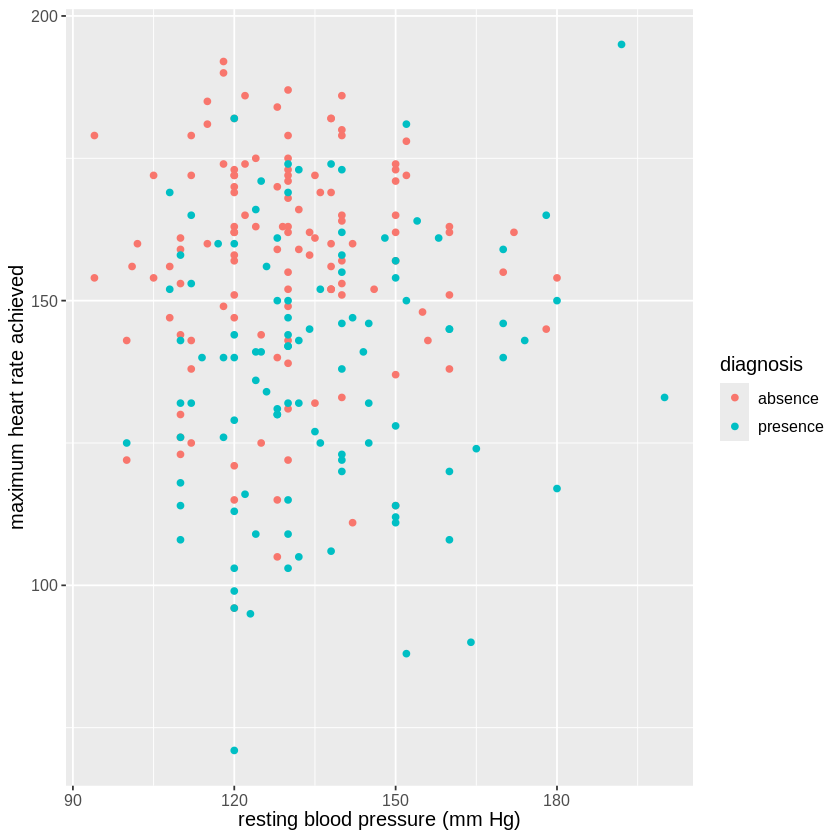

In [103]:
#split the dataset into training and testing set
heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnose)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

heart_training

#primarily exploring using the training data
num_obs <- nrow(heart_training)
heart_training |>
  group_by(diagnose) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100)
#we have roughly 54% patients diagnosed with heart disease
#now we visualize the training data by creating a scatter plot

heart_plot <- heart_training |>
select(trestbps, thalach, diagnose) |>
#we use trestbps and thalach to predict whether a patient is diagnosed or not
ggplot(aes(x = trestbps, y = thalach, colour = diagnose)) +
geom_point() +
labs(x = "resting blood pressure (mm Hg)", y = "maximum heart rate achieved",
     colour = "diagnosis") +
theme(text = element_text(size = 12))
heart_plot

Method: The complete list of predictors and their explanations are given by the UCI website:
1. #3  (age)        2. #4  (sex)         3. #9  (cp)          4. #10 (trestbps)    5. #12 (chol)        6. #16 
      7. #19 (restec
      8. #32 (thala
      9. #38 (exan1
      10. #40 (old  
      11. #41 (sl   
      12. #44 (c    
      13. #51 (     
      14. #58 (num)  
